# Deep learning for Bulldozers

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.torch_imports import *
from fastai.dataset import *
from fastai.learner import *
from fastai.structured import *
from fastai.column_data import *

# Load in our data from last lesson

In [3]:
dep = 'SalePrice'
PATH = "data/bulldozers/"
df_raw = pd.read_feather('tmp/raw')
keep_cols = list(np.load('tmp/keep_cols.npy'))

In [4]:
df_raw.loc[df_raw.YearMade<1950, 'YearMade'] = 1950
df_raw['age'] = df_raw.saleYear-df_raw.YearMade
df_raw = df_raw[keep_cols+['age', dep]].copy()
df_indep = df_raw.drop(dep,axis=1)

n_valid = 12000
n_trn = len(df_raw)-n_valid

In [5]:
cat_flds = [n for n in df_indep.columns if df_raw[n].nunique()<n_trn/50]
' '.join(cat_flds)

'YearMade Coupler_System ProductSize fiProductClassDesc ModelID saleElapsed fiSecondaryDesc Enclosure Hydraulics_Flow fiModelDesc fiModelDescriptor Hydraulics Drive_System ProductGroupDesc Tire_Size saleDay state saleWeek ProductGroup Turbocharged age'

In [6]:
cat_flds.remove('saleElapsed')
cat_flds.remove('age')
cat_flds.remove('YearMade')
[n for n in df_indep.drop(cat_flds,axis=1).columns if not is_numeric_dtype(df_raw[n])]

[]

In [7]:
for n in cat_flds: df_raw[n] = df_raw[n].astype('category').cat.as_ordered()

cont_flds = [n for n in df_indep.columns if n not in cat_flds]
' '.join(cont_flds)

'YearMade saleElapsed SalesID MachineID age'

In [8]:
df_raw = df_raw[cat_flds+cont_flds+[dep]]
df, y, mapper = proc_df(df_raw, 'SalePrice', do_scale=True)

val_idx = list(range(n_trn, len(df)))
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y, cat_flds=cat_flds, bs=64)

In [9]:
df.head()

,Coupler_System,ProductSize,fiProductClassDesc,ModelID,fiSecondaryDesc,Enclosure,Hydraulics_Flow,fiModelDesc,fiModelDescriptor,Hydraulics,...,saleDay,state,saleWeek,ProductGroup,Turbocharged,YearMade,saleElapsed,SalesID,MachineID,age
0,0,0,59,644,41,3,0,950,0,1,...,16,1,46,6,0,0.913196,0.397377,-0.858580,-0.496185,-0.828814
1,0,4,62,11,55,3,0,1725,0,1,...,26,33,13,6,0,0.405756,-0.061496,-0.858578,-2.494936,-0.430749
2,1,0,39,1542,0,6,3,331,0,4,...,26,32,9,3,0,0.722906,-0.075286,-0.858577,-1.775759,-0.762470
3,0,6,8,110,0,3,0,3674,0,1,...,19,44,20,4,0,0.722906,1.179600,-0.858574,-0.434096,-0.298060
4,1,0,40,3540,0,1,3,4208,0,4,...,23,32,30,3,0,1.103486,0.863382,-0.858572,-0.364020,-0.828814


# Model

In [10]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

In [11]:
emb_c = {n: len(c.cat.categories)+1 for n,c in df_raw[cat_flds].items()}
emb_c

{'Coupler_System': 3,
 'Drive_System': 5,
 'Enclosure': 7,
 'Hydraulics': 13,
 'Hydraulics_Flow': 4,
 'ModelID': 5219,
 'ProductGroup': 7,
 'ProductGroupDesc': 7,
 'ProductSize': 7,
 'Tire_Size': 18,
 'Turbocharged': 3,
 'fiModelDesc': 5000,
 'fiModelDescriptor': 140,
 'fiProductClassDesc': 75,
 'fiSecondaryDesc': 176,
 'saleDay': 32,
 'saleWeek': 54,
 'state': 54}

In [12]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in emb_c.items()]

In [13]:
m = md.get_learner(emb_szs, len(cont_flds), 0.05, [200,1], [0.05])

In [15]:
m.lr_find()

A Jupyter Widget

 57%|█████▋    | 3476/6081 [00:19<00:13, 195.75it/s, loss=0.551]

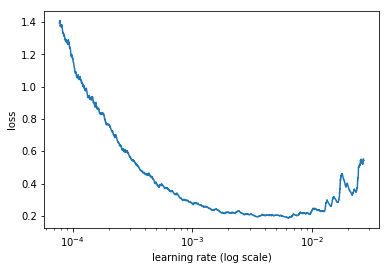

In [16]:
m.sched.plot(900)

In [15]:
lr = 1e-3

In [76]:
m.fit(1e-3, 3, 1e-6, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.      0.2444  0.1276]                                       
[ 1.      0.1648  0.091 ]                                       
[ 2.      0.1437  0.0758]                                       
[ 3.      0.1402  0.0869]                                       
[ 4.      0.123   0.0687]                                       
[ 5.      0.1039  0.0784]                                        
[ 6.      0.0981  0.0663]                                        



In [77]:
m.fit(1e-3, 3, 1e-6, cycle_len=4)

A Jupyter Widget

[ 0.      0.1096  0.0744]                                        
[ 1.      0.1007  0.0655]                                        
[ 2.      0.0859  0.0653]                                        
[ 3.      0.0824  0.0622]                                        
[ 4.      0.0954  0.1359]                                        
[ 5.      0.0794  0.071 ]                                        
[ 6.      0.0746  0.0604]                                        
[ 7.      0.0726  0.0572]                                        
[ 8.      0.0789  0.0582]                                        
[ 9.     0.074  0.061]                                           
[ 10.      0.069   0.062]                                        
[ 11.       0.0667   0.056 ]                                     



In [78]:
m.fit(1e-3, 1, 1e-6, cycle_len=8)

A Jupyter Widget

[ 0.      0.0814  0.0662]                                        
[ 1.      0.0668  0.0562]                                        
[ 2.      0.0675  0.0912]                                        
[ 3.      0.0618  0.0554]                                        
[ 4.      0.0607  0.0538]                                        
[ 5.      0.0579  0.0541]                                        
[ 6.      0.0556  0.0552]                                        
[ 7.      0.0546  0.0545]                                        

